### Time Series Anomaly Detection

In [48]:
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns
import pmdarima as pm
from pmdarima.model_selection import train_test_split
warnings.filterwarnings("ignore")

#### Loading the sample data

In [22]:
ts_dataframe = pd.read_csv("Anomaly Detection Data.csv")
ts_dataframe.head()

,Normalized Profit,Time Period
0,0.000000,01-01-2011
1,0.099833,01-02-2011
2,0.198669,01-03-2011
3,1.950000,01-04-2011
4,0.389418,01-05-2011


Text(0,0.5,'Normalized Profit')

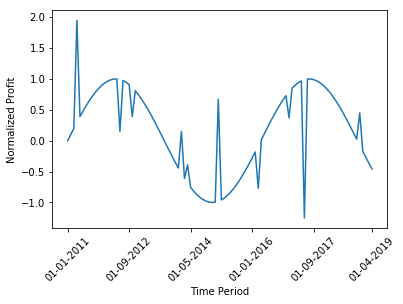

In [41]:
## Let's quickly plot and view the series
plt.plot(ts_dataframe['Time Period'], ts_dataframe['Normalized Profit'])
#ts_dataframe.plot( y = 'Normalized Profit')
plt.xlabel('Time Period')
plt.xticks([0, 20, 40, 60, 80, 99],[ts_dataframe['Time Period'][0],ts_dataframe['Time Period'][20], ts_dataframe['Time Period'][40], ts_dataframe['Time Period'][60], ts_dataframe['Time Period'][80], ts_dataframe['Time Period'][99]] ,rotation=45)
plt.ylabel('Normalized Profit')

In [42]:
# So we have a time series, having normalized profit as the y-axis and time period as the x-axis.
# The series almost looks like sinusoidal curve with some disturbances here and there, which can be the anomaly!

In [44]:
ts_dataframe.set_index('Time Period', inplace=True)
ts_dataframe.head()

,Normalized Profit
Time Period,
01-01-2011,0.000000
01-02-2011,0.099833
01-03-2011,0.198669
01-04-2011,1.950000
01-05-2011,0.389418


### Approach 1 - By Predictive Model Confidence Interval

In [46]:
def MAPE(y_orig, y_pred):
    diff = y_orig - y_pred
    MAPE = np.mean((abs(y_orig - y_pred)/y_orig)  * 100.)
    return MAPE

In [79]:
# Now, Anomaly Detection By Confidence Interval Method

# Using a simple Seasonal ARIMA model to highlight the idea, in the actual world, the model has to best fit the data
train, test = train_test_split(ts_dataframe, train_size=84)

mape = MAPE(test.values.reshape(1,-1)[0], forecast)

In [80]:
mape

10.474391496726685

Text(0,0.5,'Normalized Profit')

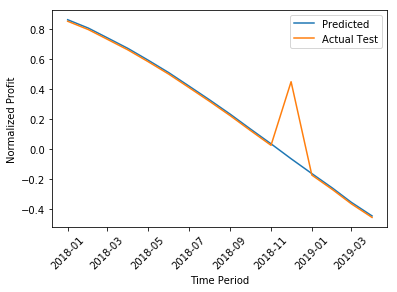

In [84]:
date = pd.date_range(start ='1-1-2018', periods = len(forecasts) , freq ='MS') 
plt.plot(date,forecast)
plt.plot(date, test.values.reshape(1,-1)[0])
plt.legend(['Predicted', 'Actual Test'])
plt.xlabel('Time Period')
plt.xticks(rotation=45)
plt.ylabel('Normalized Profit')

Text(0,0.5,'Normalized Profit')

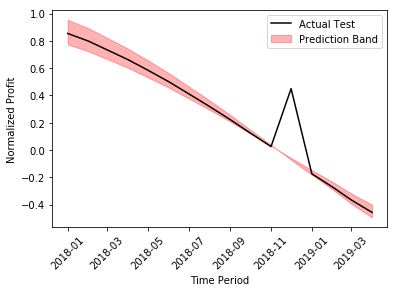

In [89]:
# upper bound and lower bound using MAPE
predicted_ub = forecast + (mape * 0.01 * forecast)
predicted_lb = forecast - (mape * 0.01 * forecast)
plot.fill_between(date, predicted_lb, predicted_ub, alpha = 0.3, color = 'red')
plt.plot(date, test.values.reshape(1,-1)[0], color = 'black')
plt.legend(['Actual Test', 'Prediction Band'])
plt.xlabel('Time Period')
plt.xticks(rotation=45)
plt.ylabel('Normalized Profit')

In [102]:
test_actuals = test.values.reshape(1,-1)[0]
anomaly_value = []
anomaly_date = []
for i in range(len(test_actuals)):
    if (abs(test_actuals[i]) > abs(predicted_ub[i]) or abs(test_actuals[i]) < abs(predicted_lb[i])):
        anomaly_value.append(test_actuals[i])
        anomaly_date.append(date[i])
        
print(anomaly_value, anomaly_date)

[0.024775425, 0.45] [Timestamp('2018-11-01 00:00:00', freq='MS'), Timestamp('2018-12-01 00:00:00', freq='MS')]


Text(0,0.5,'Normalized Profit')

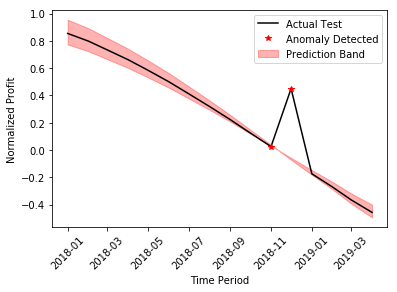

In [103]:
# upper bound and lower bound using MAPE
predicted_ub = forecast + (mape * 0.01 * forecast)
predicted_lb = forecast - (mape * 0.01 * forecast)
plot.fill_between(date, predicted_lb, predicted_ub, alpha = 0.3, color = 'red')
plt.plot(date, test.values.reshape(1,-1)[0], color = 'black')
plt.plot(anomaly_date, anomaly_value, 'r*')
plt.legend(['Actual Test', 'Anomaly Detected','Prediction Band'])
plt.xlabel('Time Period')
plt.xticks(rotation=45)
plt.ylabel('Normalized Profit')

### Approach 2 - By statistical profiling approach

In [111]:
import math
# Change - added Coalesce method to replace null value with zero
def coalesce(value):
    if math.isnan(value):
        return 0.0
    else:
        return value
    

def generate_statistical_profile(series):
    grouped_series = series.groupby(['Time Period'])['Normalized Profit'].sum().reset_index()
    grouped_series['Time Period'] = pd.to_datetime(grouped_series['Time Period'], errors='coerce')
    grouped_series['mm-yy'] =  grouped_series['Time Period'].dt.month * 10**4 + grouped_series['Time Period'].dt.year
    grouped_series['qq-yy'] =  grouped_series['Time Period'].dt.quarter * 10**4 + grouped_series['Time Period'].dt.year
    grouped_series['yy'] =  grouped_series['Time Period'].dt.year

    new_profile_m = pd.DataFrame()

    new_profile_m['max_monthly_qty'] = grouped_series.groupby(['mm-yy'])['Normalized Profit'].max().values
    new_profile_m['min_monthly_qty'] = grouped_series.groupby(['mm-yy'])['Normalized Profit'].min().values    
    new_profile_m['moving_avg_max'] = new_profile_m['max_monthly_qty'].rolling(2, min_periods=1).mean()
    new_profile_m['moving_avg_min'] = new_profile_m['min_monthly_qty'].rolling(2, min_periods=1).mean()

    new_profile_m['total_monthly_qty'] = grouped_series.groupby(['mm-yy'])['Normalized Profit'].sum().values
    new_profile_m['monthly_freq'] = grouped_series.groupby(['mm-yy'])['Normalized Profit'].count().values
    new_profile_m['moving_avg_total_m'] = new_profile_m['total_monthly_qty'].rolling(2, min_periods=1).mean()
    new_profile_m['moving_avg_freq_m'] = new_profile_m['monthly_freq'].rolling(2, min_periods=1).mean()

    new_profile_q = pd.DataFrame()
    new_profile_q['total_quarterly_qty'] = grouped_series.groupby(['qq-yy'])['Normalized Profit'].sum().values
    new_profile_q['quarterly_freq'] = grouped_series.groupby(['qq-yy'])['Normalized Profit'].count().values
    new_profile_q['moving_avg_total_q'] = new_profile_q['total_quarterly_qty'].rolling(2, min_periods=1).mean()
    new_profile_q['moving_avg_freq_q'] = new_profile_q['quarterly_freq'].rolling(2, min_periods=1).mean()

    new_profile_y = pd.DataFrame()
    new_profile_y['total_yearly_qty'] = grouped_series.groupby(['yy'])['Normalized Profit'].sum().values
    new_profile_y['yearly_freq'] = grouped_series.groupby(['yy'])['Normalized Profit'].count().values
    new_profile_y['moving_avg_total_y'] = new_profile_y['total_yearly_qty'].rolling(2, min_periods=1).mean()
    new_profile_y['moving_avg_freq_y'] = new_profile_y['yearly_freq'].rolling(2, min_periods=1).mean()

    
    statiscal_profile = [
        new_profile_m['max_monthly_qty'].median(),
        new_profile_m['moving_avg_max'].mean(),
        new_profile_m['moving_avg_max'].mean() + 0.5 * coalesce(new_profile_m['moving_avg_max'].std()),
        
        new_profile_m['min_monthly_qty'].median(),
        new_profile_m['moving_avg_min'].mean(),
        new_profile_m['moving_avg_min'].mean() - 0.5 * coalesce(new_profile_m['moving_avg_min'].std()),
        
        new_profile_m['moving_avg_total_m'].mean() + 0.5 * coalesce(new_profile_m['moving_avg_total_m'].std()),
        new_profile_m['moving_avg_freq_m'].mean() + 0.5 * coalesce(new_profile_m['moving_avg_freq_m'].std()),
        
        new_profile_m['moving_avg_total_m'].mean() - 0.5 * coalesce(new_profile_m['moving_avg_total_m'].std()),
        new_profile_m['moving_avg_freq_m'].mean() - 0.5 * coalesce(new_profile_m['moving_avg_freq_m'].std()),
        
        new_profile_q['moving_avg_total_q'].mean() + 0.5 * coalesce(new_profile_q['moving_avg_total_q'].std()),
        new_profile_q['moving_avg_freq_q'].mean() + 0.5 * coalesce(new_profile_q['moving_avg_freq_q'].std()),
        
        new_profile_q['moving_avg_total_q'].mean() - 0.5 * coalesce(new_profile_q['moving_avg_total_q'].std()),
        new_profile_q['moving_avg_freq_q'].mean() - 0.5 * coalesce(new_profile_q['moving_avg_freq_q'].std()),
        
        new_profile_y['moving_avg_total_y'].mean() + 0.5 * coalesce(new_profile_y['moving_avg_total_y'].std()),
        new_profile_y['moving_avg_freq_y'].mean() + 0.5 * coalesce(new_profile_y['moving_avg_freq_y'].std()),
        
        new_profile_y['moving_avg_total_y'].mean() - 0.5 * coalesce(new_profile_y['moving_avg_total_y'].std()),
        new_profile_y['moving_avg_freq_y'].mean() - 0.5 * coalesce(new_profile_y['moving_avg_freq_y'].std()),
    ]
    
    statiscal_profile = [round(e,2) for e in statiscal_profile]
    
    return statiscal_profile

In [114]:
def format_statistical_profile(profile_value):
    individual_profile = {}
    individual_profile["UpperThreshold"] = max(profile_value[0], profile_value[1], profile_value[2])
    individual_profile["LowerThreshold"] = min(profile_value[4], profile_value[5], profile_value[6])
    individual_profile["UTotalMonth"] = profile_value[6]
    individual_profile["UFreqMonth"] = profile_value[7]
    individual_profile["LTotalMonth"] = profile_value[8]
    individual_profile["LFreqMonth"] = profile_value[9]    
    individual_profile["UTotalQuarter"] = profile_value[10]
    individual_profile["UFreqQuarter"] = profile_value[11]
    individual_profile["LTotalQuarter"] = profile_value[12]
    individual_profile["LFreqQuarter"] = profile_value[13]     
    individual_profile["UTotalYear"] = profile_value[14]
    individual_profile["UFreqYear"] = profile_value[15]
    individual_profile["LTotalYear"] = profile_value[16]
    individual_profile["LFreqYear"] = profile_value[17]
    
    return individual_profile

In [115]:
profile_value = generate_statistical_profile(ts_dataframe.reset_index())
statistical_profile = format_statistical_profile(profile_value)

In [116]:
statistical_profile

{'LFreqMonth': 10.89,
 'LFreqQuarter': 10.89,
 'LFreqYear': 10.89,
 'LTotalMonth': -0.35,
 'LTotalQuarter': -0.35,
 'LTotalYear': -0.35,
 'LowerThreshold': -0.71,
 'UFreqMonth': 12.22,
 'UFreqQuarter': 12.22,
 'UFreqYear': 12.22,
 'UTotalMonth': 5.51,
 'UTotalQuarter': 5.51,
 'UTotalYear': 5.51,
 'UpperThreshold': 1.15}

In [124]:
test_actuals = train.values.reshape(1,-1)[0]
anomaly_value = []
anomaly_date = []
date = pd.date_range(start ='1-1-2011', periods = len(test_actuals) , freq ='MS') 
for i in range(len(test_actuals)):
    if (test_actuals[i] > statistical_profile['UpperThreshold'] or test_actuals[i] < statistical_profile['LowerThreshold']):
        anomaly_value.append(test_actuals[i])
        anomaly_date.append(date[i])
        
print(anomaly_value, anomaly_date)

[1.95, -0.756802495, -0.8182771109999999, -0.871575772, -0.916165937, -0.9516020740000001, -0.977530118, -0.9936910040000001, -0.9999232579999999, -0.996164609, -0.958924275, -0.925814682, -0.883454656, -0.832267442, -0.772764488, -0.77, -1.25] [Timestamp('2011-04-01 00:00:00', freq='MS'), Timestamp('2014-05-01 00:00:00', freq='MS'), Timestamp('2014-06-01 00:00:00', freq='MS'), Timestamp('2014-07-01 00:00:00', freq='MS'), Timestamp('2014-08-01 00:00:00', freq='MS'), Timestamp('2014-09-01 00:00:00', freq='MS'), Timestamp('2014-10-01 00:00:00', freq='MS'), Timestamp('2014-11-01 00:00:00', freq='MS'), Timestamp('2014-12-01 00:00:00', freq='MS'), Timestamp('2015-01-01 00:00:00', freq='MS'), Timestamp('2015-03-01 00:00:00', freq='MS'), Timestamp('2015-04-01 00:00:00', freq='MS'), Timestamp('2015-05-01 00:00:00', freq='MS'), Timestamp('2015-06-01 00:00:00', freq='MS'), Timestamp('2015-07-01 00:00:00', freq='MS'), Timestamp('2016-03-01 00:00:00', freq='MS'), Timestamp('2017-06-01 00:00:00', f

Text(0,0.5,'Normalized Profit')

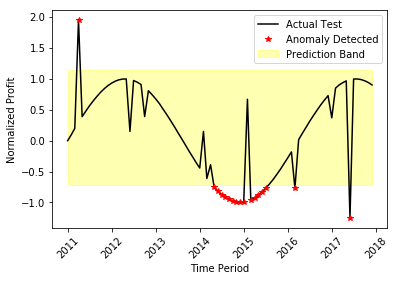

In [125]:
plot.fill_between(date,statistical_profile['LowerThreshold'], statistical_profile['UpperThreshold'], alpha = 0.3, color = 'yellow')
plt.plot(date, train.values.reshape(1,-1)[0], color = 'black')
plt.plot(anomaly_date, anomaly_value, 'r*')
plt.legend(['Actual Test', 'Anomaly Detected','Prediction Band'])
plt.xlabel('Time Period')
plt.xticks(rotation=45)
plt.ylabel('Normalized Profit')

### Approach 3 - By DBSCAN 

In [128]:
from sklearn.cluster import DBSCAN

In [186]:
clustering1 = DBSCAN(eps=0.09, min_samples=6).fit(np.array(ts_dataframe['Normalized Profit']).reshape(-1,1))
labels = clustering1.labels_

In [187]:
labels

array([ 0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
       -1,  1,  1,  0, -1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  0,  2,
        2,  2,  2,  2,  2, -1, -1,  1,  1,  1, -1,  2,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  1,  1,  1],
      dtype=int64)

Text(0,0.5,'Normalized Profit')

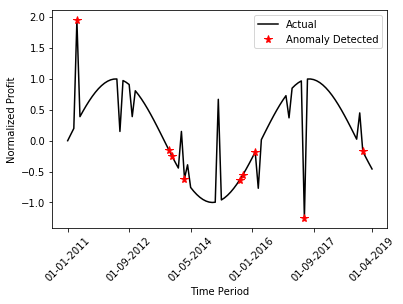

In [188]:
outlier_pos = np.where(labels == -1)[0]

x = []; y = [];
for pos in outlier_pos:
    x.append(np.array(ts_dataframe['Normalized Profit'])[pos])
    y.append(ts_dataframe['Normalized Profit'].index[pos])
    
plt.plot(ts_dataframe['Normalized Profit'].loc[ts_dataframe['Normalized Profit'].index], 'k-')
plt.plot(y,x,'r*', markersize=8)  
plt.legend(['Actual', 'Anomaly Detected'])
plt.xlabel('Time Period')
plt.xticks([0, 20, 40, 60, 80, 99],[ts_dataframe.index[0],ts_dataframe.index[20], ts_dataframe.index[40], ts_dataframe.index[60], ts_dataframe.index[80], ts_dataframe.index[99]] ,rotation=45)
plt.ylabel('Normalized Profit')

In [ ]:
## End!